In [1]:
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
project_root = Path().resolve().parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from functions.calculate_proximity import calculate_peer_weights, plot_average_importance
from functions.load_datasets import organize_financial_data_by_year
from functions.calculate_monthly_returns import calculate_monthly_returns
from functions.load_datasets import load_datasets
from functions.create_features import create_features
from functions.create_monthly_feature_data import create_monthly_feature_data
from functions.calculate_ml_signal import calculate_ml_signal
from functions.analyze_peer_industry import analyze_peer_industry_match
from functions.extract_peer_companies import get_peer_pbr_analysis


In [3]:
data_path = str(project_root) + "/data/"

config = {
    "df_sales": ("sales.xls", 1),
    "df_capital": ("capital.xls", 1),
    "df_cogs_ratio": ("cost.xls", 1),
    "df_sga_ratio": ("cost.xls", 2),
    "df_roic": ("roic.xls", 1),
    "df_rd_ratio": ("rd_profit.xls", 1),
    "df_opm": ("rd_profit.xls", 2),
    "df_roe": ("roe.xls", 1),
    "df_interest": ("interest_expenses.xls", 1),
}

dfs = {
    name: pd.read_excel(data_path + file, sheet_name=sheet).rename(columns={"Unnamed: 0": "Company"})
    for name, (file, sheet) in config.items()
}

years = list(range(2025, 2019, -1))
financial_dfs = organize_financial_data_by_year(dfs, years)
df_industry = pd.read_excel(data_path + "nikkei_industry.xls", sheet_name=1).dropna().rename(columns={"Unnamed: 0": "Company"}).set_index("Company").drop_duplicates()
df_industry = df_industry[~df_industry.index.duplicated(keep='first')].dropna()

In [4]:
df_pbr, df_stp, df_mktcap = load_datasets(data_path)
df_returns = calculate_monthly_returns(df_stp)

In [5]:
monthly_feature_data = create_monthly_feature_data(financial_dfs, df_pbr, df_industry)

print(f"月次特徴量データの作成完了")
print(f"利用可能な月数: {len(monthly_feature_data)}")

# データ構造の確認
available_months = sorted(monthly_feature_data.keys())
if len(available_months) > 0:
    print(f"\n最初の月: {available_months[0]}")
    print(f"最後の月: {available_months[-1]}")
    print(f"\n例 (2021/01): 形状 = {monthly_feature_data.get('2021/01', pd.DataFrame()).shape if '2021/01' in monthly_feature_data else 'なし'}")
    if '2021/01' in monthly_feature_data:
        print(f"  → 使用財務データ: 2020年度 (2020/06から利用可能)")
    print(f"\n例 (2021/06): 形状 = {monthly_feature_data.get('2021/06', pd.DataFrame()).shape if '2021/06' in monthly_feature_data else 'なし'}")
    if '2021/06' in monthly_feature_data:
        print(f"  → 使用財務データ: 2021年度 (2021/06から利用可能)")

月次特徴量データの作成完了
利用可能な月数: 67

最初の月: 2020/06
最後の月: 2025/12

例 (2021/01): 形状 = (4007, 12)
  → 使用財務データ: 2020年度 (2020/06から利用可能)

例 (2021/06): 形状 = (4007, 12)
  → 使用財務データ: 2021年度 (2021/06から利用可能)


分析対象月: 2025/12
学習データ: 12ヶ月分、48084サンプル
現在月データ: 4007社
corr: 0.9126, rmse: 0.3400
類似企業（上位10社）の業種一致度分析
分析対象企業数: 3985

同業種企業数の分布:
  平均: 8.43 / 10
  中央値: 10.0 / 10
  標準偏差: 2.50
  最小: 0
  最大: 10

同業種割合の平均: 84.4%


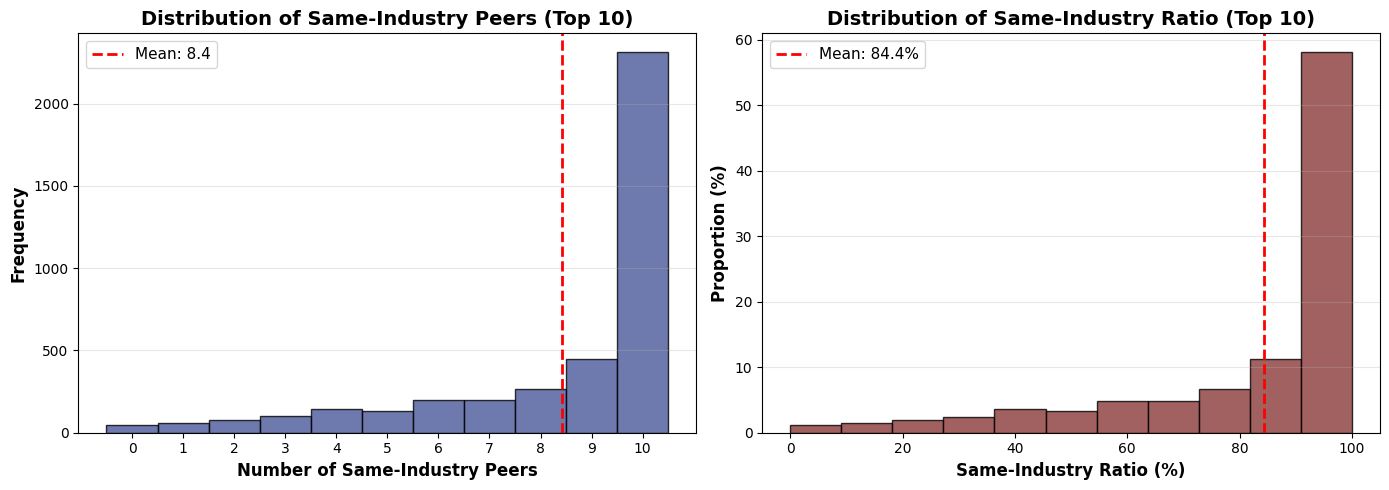

In [6]:
# 最新の利用可能な月を取得
available_months = sorted([m for m in monthly_feature_data.keys()])
latest_month = available_months[-1]

print(f"分析対象月: {latest_month}")
print("=" * 70)

# 最新月の特徴量データを取得
current_df = monthly_feature_data[latest_month].copy()

# 学習データを準備（過去12ヶ月分）
lookback_months = 12
latest_idx = len(available_months) - 1
past_months = available_months[max(0, latest_idx - lookback_months):latest_idx]

train_dfs = [monthly_feature_data[m] for m in past_months if m in monthly_feature_data]
train_df = pd.concat(train_dfs, axis=0)

print(f"学習データ: {len(train_dfs)}ヶ月分、{len(train_df)}サンプル")
print(f"現在月データ: {len(current_df)}社")

# 類似度計算
weights_df, _ = calculate_peer_weights(
    train_df=train_df,
    current_features_df=current_df,
    top_k=10,
    num_boost_round=100
)

# 業種一致度分析（ヒストグラム描画）
result_df = analyze_peer_industry_match(
    weights_df=weights_df,
    df_industry=df_industry,
    top_k=10,
    show_plot=True,
    industry_col="日経業種中分類"
)

In [7]:
result = get_peer_pbr_analysis("野村不動産ホールディングス", weights_df, df_pbr, df_industry)
print(f"実際のPBR: {result['actual_pbr']}")
print(f"\n類似企業10件:")
print(result['peer_df'])
print(f"\n重みづけ平均PBR: {result['weighted_avg_pbr']}")

実際のPBR: 1.1865

類似企業10件:
               会社名       類似度     PBR     業種
0            三井不動産  0.109677  1.5326    不動産
1             東京建物  0.109677  1.3321    不動産
2            住友不動産  0.104839  1.5924    不動産
3             東武鉄道  0.104839  0.9026  鉄道・バス
4    東急不動産ホールディングス  0.103226  1.2161    不動産
5             岩谷産業  0.098387  0.9681     商社
6            小田急電鉄  0.093548  1.2763  鉄道・バス
7           九州旅客鉄道  0.091935  1.3371  鉄道・バス
8  三重交通グループホールディング  0.091935  0.8675    不動産
9               東急  0.091935  1.3278  鉄道・バス

重みづけ平均PBR: 1.2406956451612905


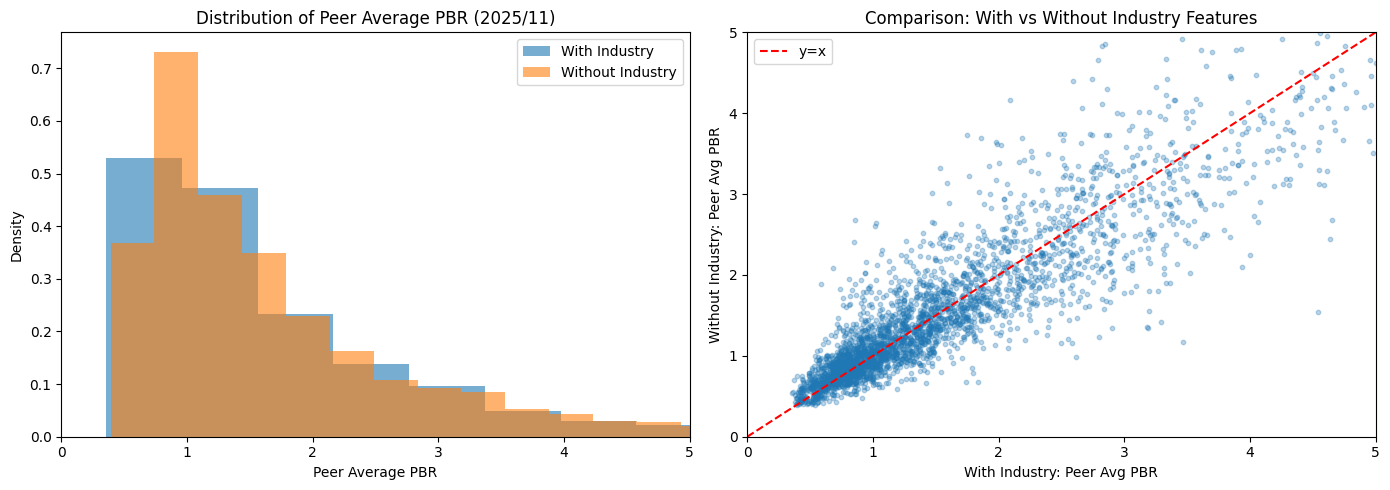


【Statistics (2025/11)】
With Industry:    mean=1.919, std=2.042, nunique=3289
Without Industry: mean=1.870, std=1.764, nunique=3289
Correlation: 0.902


In [9]:
# Load data
with open('debug_with_industry.pkl', 'rb') as f:
    data_with = pickle.load(f)
with open('debug_without_industry.pkl', 'rb') as f:
    data_without = pickle.load(f)

# Get first month's data
latest_month = list(data_with['peer_avg_pbr'].keys())[0]
pap_with = data_with['peer_avg_pbr'][latest_month]
pap_without = data_without['peer_avg_pbr'][latest_month]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram comparison
axes[0].hist(pap_with.dropna(), bins=50, alpha=0.6, label='With Industry', density=True)
axes[0].hist(pap_without.dropna(), bins=50, alpha=0.6, label='Without Industry', density=True)
axes[0].set_xlabel('Peer Average PBR')
axes[0].set_ylabel('Density')
axes[0].set_title(f'Distribution of Peer Average PBR ({latest_month})')
axes[0].legend()
axes[0].set_xlim(0, 5)

# Right: Scatter plot (with vs without industry)
common = pap_with.index.intersection(pap_without.index)
axes[1].scatter(pap_with[common], pap_without[common], alpha=0.3, s=10)
axes[1].plot([0, 5], [0, 5], 'r--', label='y=x')
axes[1].set_xlabel('With Industry: Peer Avg PBR')
axes[1].set_ylabel('Without Industry: Peer Avg PBR')
axes[1].set_title('Comparison: With vs Without Industry Features')
axes[1].set_xlim(0, 5)
axes[1].set_ylim(0, 5)
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistics
print(f'\n【Statistics ({latest_month})】')
print(f'With Industry:    mean={pap_with.mean():.3f}, std={pap_with.std():.3f}, nunique={pap_with.nunique()}')
print(f'Without Industry: mean={pap_without.mean():.3f}, std={pap_without.std():.3f}, nunique={pap_without.nunique()}')
print(f'Correlation: {pap_with[common].corr(pap_without[common]):.3f}')